<a href="https://colab.research.google.com/github/JairEsc/Mat_Apl/blob/main/Opt_Proyecto_derivative_free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt

In [54]:
def BFGS(s_k,y_k,g_k,H_k):
    n=len(s_k)
    I=np.identity(n)
    rho=1/max(np.dot(s_k,y_k),10**(-8))
    M_1=np.outer(s_k,y_k)
    M_2=np.outer(y_k,s_k)
    H_k_m=np.dot((I-rho*M_1),np.dot(H_k,(I-rho*M_2)))+rho*np.outer(s_k,s_k)
    return H_k_m
def L_BFGS(S,Y,g):#Checar las posibles divisiones por cero
    n=len(g)
    m=len(S)
    #supondremos H_0 un multiplo de la identidad
    H_0=(np.dot(S[-1],Y[-1])/(np.dot(Y[-1],Y[-1])))*np.identity(n)#Dado en clase.
    q=g
    alphas=[]
    for i in range(m):
        alphas.append((1/max(10**(-6),np.dot(S[m-1-i],Y[m-1-i])))*np.dot(S[m-1-i],q))
        q=q-alphas[i]*Y[m-1-i]
    r=np.dot(H_0,q)
    for i in range(m):
        beta=(1/max(10**(-6),np.dot(Y[i],Y[i])))*np.dot(Y[i],r)
        r=r+S[i]*(alphas[m-1-i]-beta)#aproximacion de -H*g
    return r

Idea general del algoritmo.

Input: 


*   $f:\mathbb{R}^n⟶ \mathbb{R}$, función objetivo.
*   $x_0$, aproximación inicial.
*   $a_{max}$, Número máximo de iteraciones para la busqueda en linea.
*   $\zeta$, parámetro de curvatura.
*   $tol_g$, criterio de paro para la norma del gradiente.



Descripción general del algoritmo (Ver Derivative-free optimization, pag 9.)

*   Calcular $f(x_0)$
*   Estimar $\epsilon_f$ usando ECnoise*
*   Calcular ** h
*   Calcular $\nabla_h f(x_0)$. Cuando se haga, guardar los valores $(x_s,f_s)$ que satisfacen $f_s=f(x_s)=min_{x\in S} f(x)$, $S=\{x+h\cdot e_i,i=1,\ldots,n\}$
*   While ($||\nabla f(x_k)||>tol_g$):
    *   Calcular $d_k=-H_k\nabla_h f(x_k)$ usando L-BFGS***
    *   Hacer line_search$(x_k,f_k,\nabla_h f(x_k),d_k,a_{max})$ y obtiene $(x_+,f_+,\alpha_k,LS_{flag})$
        *   If($LS_{flag}==1$):
            *   Invocar Recovery($x_s,f_s$)
        *   Else:
            *   Actualizar $x_{k+1}=x_+,$ $f_{k+1}=f_+$
    *   Calcular $\nabla_h f(x_{k+1})$ y guardar $(x_s,f_s)$
    *   Calcular $s_k=x_{k+1}-x_k$, $y_k=\nabla_h f(x_{k+1})-\nabla_h f(x_k)$
        *   Guardarlos si $s_k^Ty_k\geq \zeta||s_k||||y_k||$

Explicación de L-BFGS: (Ver clase en Moodle.)

Si $H_k$ es una aproximación de la inversa del Hessiano, nos interesa caluclar $d_k=-H_k\nabla f(x_k)$.


Input:



*   $\nabla f(x_k)$
*   $\{(s_{k-1},y_{k-1}),(s_{k-2},y_{k-2}),\ldots,(s_{k-m},y_{k-m})\}$
*   $H^0_{k-m}$

Algoritmo:


*   Define $q=\nabla f(x_k)$
*   for $i=1,2,\ldots,m$ do:
    *   Calcular $\alpha_i=\rho_i s_{k-i}^Tq$
    *   Actualiza $q=q-\alpha_iy_i$
*   Define $r=H^0_{k-m}q$
*   for $i=1,2,\ldots,m$ do:
    *   Calcular $\beta=\rho_{k-i}y_{k-i}^Tr$
    *   Actualiza $r=r-s_{k-i}(\alpha_i-\beta)$
*   $r$ es una aproximación de $H_k\nabla f(x_k)$


In [3]:
def ECNoise(F):#F es un vector que guarda f(t_i), i=0,...,m. Evaluaciones de m+1 puntos equiespaciados
#Ver metodo en Estimating_Computational_Noise, pagina 8
    m=len(F)-1
    T=np.zeros((m+1,m+1))
    for i in range(m+1):
        T[i,0]=F[i]
    for k in range(m):
        for i in range(m-k):
            T[i,k+1]=T[i+1,k]-T[i,k]
    return T

In [4]:
def var_estimation(T):#Recibe la tabla.
    m=len(T)-1
    sigma_array=[]
    for k in range(1,m):
        sigma_array.append(((np.math.factorial(k)/np.math.factorial(2*k))/(m+1-k))*np.sum(T.T[k]**2))
    #Ahora checamos las 2 condiciones.
    for k in range(1,m-2):
        max_k=np.max(sigma_array[k:k+2])
        min_k=np.min(sigma_array[k:k+2])
        if(max_k<=4*min_k):
            if(np.sign(min_k*max_k)==-1):
                print("es el ", k)
                break
    return np.sqrt(sigma_array[k])#Podria ser que las condiciones no se cumplan, en tal caso regresa la ultima estimacion sigma.

In [5]:
def aprox_f_biprima(e_f,f,x_k,p):#Usando una direccion (aleatoria dada) se aproxima el max ||Hessiana_f(x_k)*p||
    #Ver Estimating Derivatives of Noisy Simulations, pagina 14.
    tao_1=100
    tao_2=0.1
    h_a=e_f**(1/4)
    f_mas=f(x_k+h_a*p)
    f_menos=f(x_k-h_a*p)
    f_0=f(x_k)
    delta_h_a=abs(f_mas+f_menos-2*f_0)
    mu_a=delta_h_a/(h_a**2)
    if(delta_h_a/e_f>=tao_1):
        mu=mu_a
        if(abs(f_mas-f_0)<=tao_2*max(f_mas,f_menos,f_0) and abs(f_menos-f_0)<=tao_2*max(f_mas,f_menos,f_0)):
            return mu_a
    h_b=(e_f/mu_a)**(1/4)
    f_mas=f(x_k+h_b*p)
    f_menos=f(x_k-h_b*p)
    delta_h_b=abs(f_mas+f_menos-2*f_0)
    mu_b=delta_h_b/(h_b**2)
    if(delta_h_b/e_f>=tao_1):
        mu=mu_b
        if(abs(f_mas-f_0)<=tao_2*max(f_mas,f_menos,f_0) and abs(f_menos-f_0)<=tao_2*max(f_mas,f_menos,f_0)):
            return mu_b
    if(abs(mu_a-mu_b)<=0.5*mu_b):
        return mu_b
    print("No hay regla de decision")
    return mu_b#Por falta de relga de descicion. En el algoritmo no se especifica una opcion.


In [58]:
def rutina_h(f,p,x_0,m=6):#Calcula h a partir de una direccion dada, con m+1 puntos equiespaciados.
    f_0=f(x_0)
    n=len(x_0)
    delta=10**(-3)#Suggested by ECnoise algorithm.
    F=[f(x_0+delta*i*p) for i in range(m)]
    T=ECNoise(F)
    e_f=var_estimation(T)
    #print("e_f: ",e_f)#Breakpoint
    mu=aprox_f_biprima(e_f=e_f,f=f,x_k=x_0,p=p)
    h=(8**(1/4))*(e_f/mu)**(1/2)
    return e_f,h

In [7]:
def Rosembrok(X):#X es un vector.
    return (np.sum(100*(X[1:]-X[:-1]**2)**2+(1-X[:-1])**2)+10**(-3)*np.random.uniform(0,1))#Ruido
def Rosembrok_grad(X):
    return scipy.optimize.approx_fprime(f=Rosembrok,xk=X,epsilon=10**(-4))
def Rosembrok_grad_real(X):
    D=[]
    D.append(-400*(X[0]*(X[1]-X[0]**2))-2*(1-X[0]))
    for i in range(1,len(X)-1):
        D.append(-400*(X[i]*(X[i+1]-X[i]**2))+200*(X[i]-X[i-1]**2)-2*(1-X[i]))
    D.append(200*(X[-1]-X[-2]**2))
    return D
def Rosembrok_Hessian(X):
    M=[]
    #Renglon 1
    D=np.zeros(len(X))
    D[0]=(-400*(X[1]-X[0]**2)+800*(X[0]**2)+2)
    D[1]=-400*(X[1])
    M.append(D)
    #Renglon 2<i<n
    for i in range(1,len(X)-1):
        D=np.zeros(len(X))
        D[i]=(-400*(X[i+1]-X[i]**2)+800*(X[i]**2)+202)
        D[i-1]=-400*X[i-1]
        D[i+1]=-400*X[i]
        M.append(D)
    #Renglon n
    D=np.zeros(len(X))
    D[-2]=-400*X[-2]
    D[-1]=200
    M.append(D)
    return M

In [8]:
#Muestra de la estimacion del gradiente con Forward difference.
n=10
x_k=np.random.uniform(0,1,size=n)
p=np.eye(1,len(x_k),np.random.randint(0,len(x_k)))
e_f,h=rutina_h(f=Rosembrok,p=p,m=6,x_0=x_k)
print(h)
print(Rosembrok_grad(x_k))
print(Rosembrok_grad_real(x_k))
#------------------------------------------------------

No hay regla de decision
4.064025305546656e-06
[-108.53934158  340.48987312 -156.39354279  -11.61353798  -34.26124306
  465.65063116 -184.42402519   -4.60041069   40.50331706   53.40059073]
[-110.2233592448095, 342.9592269099771, -156.17963913628498, -10.659704871937954, -35.285933345410996, 460.053015793859, -184.62829870993193, -10.512745503385077, 36.55115343900333, 47.045775206257105]


In [25]:
def relaxed_Armijo(x_k,f,fprime,d,e_f,c_1=0.001,c_2=0.9,max_iter=10**2):##Intenté usar scipy.line_search(), pero Strong Wolfe son dificiles de satisfacerse
    #Metodo visto en clase.
    iter=0
    alpha_0=1
    alpha=0
    grad_f_k=fprime(x_k)
    f_k=f(x_k)
    beta=np.inf
    alpha_i=alpha_0
    alpha_armijo=0
    for i in range(max_iter):
        if(f(x_k+alpha_i*d)>f_k+c_1*alpha_i*np.dot(grad_f_k,d)+2*e_f):#Aqui esta la condicion relajada, dado e_f estimacion del error estandar.
            beta=alpha_i
            alpha_i=0.5*(alpha+beta)
        else:
            alpha_armijo=alpha_i
            if(np.dot(fprime(x_k+alpha_i*d),d)<c_2*np.dot(grad_f_k,d)):
                alpha=alpha_i
                if(beta==np.inf):
                    alpha_i=2*alpha
                else:
                    0.5*(alpha+beta)
            else:
                return alpha_i
    return alpha_armijo

In [59]:
def recovery(x_k,f,grad_k,e_f,h,l1,l2,d_k,m=6):#Genera un nuevo h
    e_f_b,h_b=rutina_h(f=f,p=d_k,m=m,x_0=x_k)
    n=len(d_k)
    f_k=f(x_k)
    if(h_b<l1*h or h_b>l2*h):
        return e_f_b,h_b
    else:
        d_k=d_k/np.linalg.norm(d_k)
        x_h=x_k+h*(d_k)
        f_h=f(x_h)
        if(f_h<=f(x_k)+0.001*h*np.dot(grad_k,d_k)+2*e_f):
            return e_f,h
        else:
            f_stencil=[f(x_k+h*np.eye(1,n,i)) for i in range(n)]
            f_s=np.min(f_stencil)
            if(f_h<=f_s and f_h<=f_k):
                return e_f,h
            else:
                if(f_k>f_s and f_h>f_s):
                    return e_f,h
                else:
                    e_f_n,h_n=rutina_h(f=f,p=np.random.uniform(-1,1,size=n),m=m,x_0=x_k)
                    return e_f_n,h_n

In [66]:
def ros_chiquito(f,x_0,tol_g=10**(-4),max_iter=10**2):
    #----------------------
    #Listas
    iter=0
    GG=[]
    Y=[]
    S=[]
    #----------------------
    #----------------------
    g_0=Rosembrok_grad(x_0)#Gradiente REAL
    alpha_k=scipy.optimize.line_search(f=f,myfprime=Rosembrok_grad,xk=x_0,pk=-g_0)[0]#line_search
    x_1=x_0-alpha_k*g_0#Primera direccion de descenso es -grad(x_0)
    g_1=Rosembrok_grad(x_1)
    e_f,h=rutina_h(f=f,p=np.random.uniform(-1,1,size=n),m=6,x_0=x_0)
    #----------------------
    y_k=(g_1-g_0)#diferencia de gradientes
    s_k=-alpha_k*g_0#diferencia de x's
    Y.append(y_k)
    S.append(s_k)
    d_k_r=-np.dot(np.linalg.inv(Rosembrok_Hessian(x_0)),g_0)#Direccion de Newton REAL
    #comp=[np.linalg.norm(d_k_r+g_0)]#Lista para compararlos
    H_k=(np.dot(s_k,y_k)/(np.dot(y_k,y_k)))*np.identity(n)#Dado en clase.
    #----------------------
    while(np.linalg.norm(g_1)>tol_g and iter<max_iter):
        x_0=x_1
        g_0=g_1
        #H_k_m=BFGS(s_k=s_k,y_k=y_k,g_k=0,H_k=H_k)
        #d_k_r=-np.dot(np.linalg.inv(Rosembrok_Hessian(x_0)),g_0)
        d_k_l=-L_BFGS(S=S,Y=Y,g=g_1)
        #d_k=-np.dot(H_k_m,g_0)
        if(iter>50):
            S=S[-50:-1]
            Y=Y[-50:-1]
        alpha_k_try=relaxed_Armijo(f=f,fprime=Rosembrok_grad,x_k=x_0,d=d_k_l,e_f=e_f,)#line_search
        if(alpha_k_try>0):
            alpha_k=alpha_k_try
        else:
            e_f,h=recovery(x_k=x_0,f=f,grad_k=g_0,e_f=e_f,h=h,l1=0.4,l2=2.5,d_k=d_k_l)
            alpha_k_try=relaxed_Armijo(f=f,fprime=Rosembrok_grad,x_k=x_0,d=d_k_l,e_f=e_f,max_iter=10**6)#line_search
            if(alpha_k_try==0):
                print("Y ahora que")
                break
            else: 
                alpha_k=alpha_k_try
        x_1=x_0+alpha_k*d_k_l#
        g_1=Rosembrok_grad(x_1)
        iter+=1
        #H_k=H_k_m
        y_k=(g_1-g_0)#diferencia de gradientes
        s_k=alpha_k*d_k_l#diferencia de x's
        Y.append(y_k)
        S.append(s_k)
        #print(np.linalg.norm(d_k-d_k_l))
        GG.append(np.linalg.norm(g_1))
    print("norm:",GG[-1])
    #print("comp:",comp[-1])
    plt.plot(GG)
    plt.show()
    return x_1

norm: 48.836901314817496


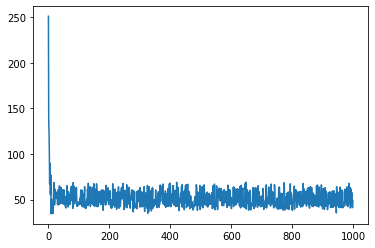

array([1.00708104, 1.0064415 , 1.00211189, 1.00194441, 1.00199746,
       1.0030875 , 0.99856094, 0.997769  , 0.99966161, 0.99777138,
       0.99152523, 0.99432066, 0.98950249, 0.99555695, 0.99607998,
       0.99001444, 0.98899767, 0.99230332, 0.9892886 , 0.99929624,
       1.00387159, 1.00106587, 0.99227983, 0.98850213, 0.98526035,
       0.98894812, 0.98707626, 0.98842542, 0.99228382, 0.99917281,
       1.00067322, 0.99653899, 0.99102443, 0.99816546, 1.00084758,
       0.99868354, 1.00540344, 1.00341986, 1.00353965, 1.00566237,
       1.00400057, 1.00932986, 1.00320454, 1.00014683, 0.9893208 ,
       0.99863102, 0.99990254, 1.00013545, 0.99834101, 1.00035507,
       1.00407978, 1.00647804, 1.00721648, 1.00562815, 1.00793595,
       1.00817985, 1.00795734, 1.00595689, 1.00258399, 1.00205359,
       0.99191154, 0.9967385 , 1.00144061, 1.00229141, 1.00699721,
       1.00392078, 0.99711021, 0.99573336, 0.99522718, 0.99640535,
       1.00502483, 1.00690503, 1.00318339, 1.00339688, 0.99969

In [67]:
n=100
x_0=np.random.uniform(.7,1.3,size=n)
ros_chiquito(f=Rosembrok,x_0=x_0,tol_g=10**(-4),max_iter=1000)

In [ ]:
import matplotlib.pyplot as plt

def find_minimum(f,x_0,m,a_max,zeta,tol_g,max_iter=10**2):
    f_0=f(x_0)
    n=len(x_0)
    p=np.random.uniform(-1,1,size=n)#Direccion aleatoria
    p=p/np.linalg.norm(p)
    #Rutina_h-----------------
    delta=10**(-3)#Suggested by ECnoise algorithm.
    F=[f(x_0+delta*i*p) for i in range(m)]
    T=ECNoise(F)
    e_f=var_estimation(T)
    print("e_f: ",e_f)#Breakpoint
    mu=aprox_f_biprima(e_f=e_f,f=f,x_k=x_0,p=p)
    h=(8**(1/4))*(e_f/mu)**(1/2)
    print("h: ", h)
    #-------------------
    def fprime(x):
        return scipy.optimize.approx_fprime(f=f,xk=x,epsilon=h**(1/3))
    g_0=fprime(x_0)
    Y=[]
    S=[]
    #print(g_0)
    #Una iteracion
    iter=1
    alpha_k=relaxed_Wolfe(x_k=x_0,f=f,fprime=fprime,d=-g_0,e_f=e_f,c_1=0.001,c_2=0.9,max_iter=10**4)
    x_1=x_0-alpha_k*g_0#Actualizar x_k+1
    f_k_m=f(x_1)
    g_1=fprime(x_1)
    Y.append(g_1-g_0)#diferencia de gradientes
    S.append(-alpha_k*g_0)#diferencia de x's
    GG=[]#Para guardar las normas de los gradientes y ver el progreso.
    while(np.linalg.norm(g_1)>tol_g and iter<max_iter):
        x_0=x_1
        g_0=g_1
        d_k=L_BFGS(S=S,Y=Y,g=g_1)#Calcula direccion de descenso.
        alpha_k=relaxed_Wolfe(x_k=x_0,f=f,fprime=fprime,d=d_k,e_f=e_f,c_1=0.001,c_2=0.9,max_iter=10**4)#Tamaño de paso.
        x_1=x_0+alpha_k*d_k
        f_k_m=f(x_1)
        g_1=fprime(x_1)
        Y.append(g_1-g_0)
        S.append(x_1-x_0)
        iter+=1
        GG.append(np.linalg.norm(x_1))
    plt.plot(GG)
    print("norma del gradiente final: ",GG[-2])##Antes del error si es que falla.
    return x_1

In [ ]:
#Test--------------------
#x_0=np.random.uniform(0,1,size=100)
#w=find_minimum(f=Rosembrok,x_0=w,m=6,a_max=100,zeta=0.5,tol_g=10**(-2),max_iter=10)
#---------------------